[View in Colaboratory](https://colab.research.google.com/github/rdenadai/dsp_study_notebooks/blob/master/notebooks/dsp101c.ipynb)

## DSP 101c

Experiments on Digital Signal Processing, ranging from random generated signals, voice and images!

In these experiments, we are not analysing signals in the range of DSP but also with an statistical view...

To build this document we use a lot of resources, here are some of the most important.
- References:
 - [DSP Guide](http://www.dspguide.com)
 - [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy)
 - [DSP Tutorial](https://www.tutorialspoint.com/digital_signal_processing/index.htm)
 - [Plotly FFT Filters](https://plot.ly/python/fft-filters/)
 - [Digital Signal Processing {youtube}](https://www.youtube.com/playlist?list=PLuh62Q4Sv7BUSzx5Jr8Wrxxn-U10qG1et)
 - [Signal Processing 101 {youtube}](https://www.youtube.com/watch?v=KZd68xgasIU&list=PLJ-OcUCIty7evBmHvYRv66RcuziszpSFB)
 - [All Signal Processing {youtube}](https://www.youtube.com/user/allsignalprocessing/playlists)


In [0]:
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import resample
from scipy import interpolate
from scipy import signal
from scipy import fftpack
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import Audio

%matplotlib inline

def normalization(x, m=255):
    return (((x - min(x)) / (max(x) - min(x))) * m).astype('int64')

def normalization2(x, a, b):
    return (a + (((x - min(x)) * (b - a)) / (max(x) - min(x)))).astype('float64')

In [0]:
def sine(A=4096, f=1, t=1, Fs=1024, phi=0):
    # A = 4096              # amplitude (deslocamento vertical)
    # phi = 0               # fase (deslocamento horizontal)
    # f = 1                 # frequencia em hz (quantas oscilações em 1 segundo)
    # t = 1                 # tempo em segundos
    # Fs = 200              # frequencia de amostragem (pontos por segundo)
    n = np.arange(Fs * t)
    return (A * np.sin((((2 * np.pi * f) * n) / Fs) + phi)).astype('int64')

def resamp_presenter(x, num):
    y = np.zeros(x.size)
    y[y==0] = np.nan
    y[::num] = x[::num]
    return y, math.ceil(len(x) / num)

def resamp(x, num):
    return x[::num]

## Discrete Fourier Transform

> "*In mathematics, the discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency.*" [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)

[DSP Guide](http://www.dspguide.com/ch8/1.htm) define 4 types of Fourir Transform depending on signal:

**Aperiodic-Continuous:**

This includes, for example, decaying exponentials and the Gaussian curve. These signals extend to both positive and negative infinity without repeating in a periodic pattern. The Fourier Transform for this type of signal is simply called the Fourier Transform.

**Periodic-Continuous:**

Here the examples include: sine waves, square waves, and any waveform that repeats itself in a regular pattern from negative to positive infinity. This version of the Fourier transform is called the Fourier Series.

**Aperiodic-Discrete:**

These signals are only defined at discrete points between positive and negative infinity, and do not repeat themselves in a periodic fashion. This type of Fourier transform is called the Discrete Time Fourier Transform.

**Periodic-Discrete:**

These are discrete signals that repeat themselves in a periodic fashion from negative to positive infinity. This class of Fourier Transform is sometimes called the Discrete Fourier Series, but is most often called the Discrete Fourier Transform.

------------------------------------
"*The **FFT** is a fast, $O[NlogN]$ algorithm to compute the Discrete Fourier Transform (DFT), which naively is an $O[N^2]$ computation. The DFT, like the more familiar continuous version of the Fourier transform, has a forward and inverse form which are defined as follows:*" [jakevdp](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)

**Forward Discrete Fourier Transform (DFT):**

$ X_k=\sum_{n=0}^{N−1}x_ne^{−i 2\pi k n / N} $

**Inverse Discrete Fourier Transform (IDFT):**

$ x_n=\frac{1}{N}\sum_{k=0}^{N−1}X_ke^{i 2\pi k n / N} $

FFT of Z: [10.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.-0.j  0.-0.j
  0.-0.j]


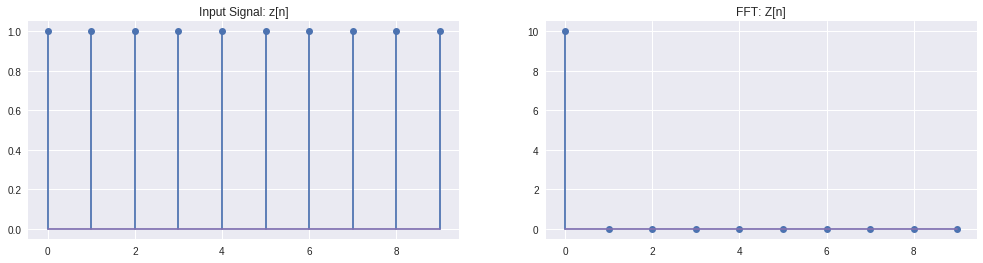

In [8]:
z = np.ones(10)
#z[::2] = -1
Z = fftpack.fft(z)

print(f'FFT of Z: {Z}')

fig = plt.figure(figsize=(17, 4))
plt.subplot(121)
plt.title('Input Signal: z[n]')
plt.stem(z)
plt.subplot(122)
plt.title('FFT: Z[n]')
plt.stem(Z.real)
plt.show()

Bellow is an example of FFT use, two different frequency sinusoids are merged together and it's frequency domain spectre are show two different frequencies.

A low frequency at 50 Hz and high frequency at 150 Hz.

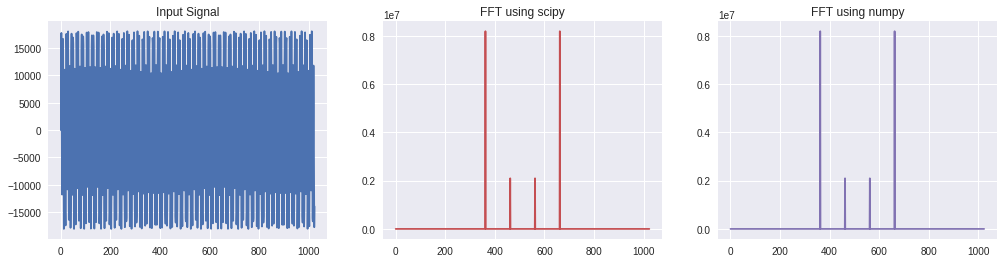

In [6]:
x = sine(f=50, t=1) + sine(A=16000, f=150, t=1)
X_sc = np.abs(np.fft.fftshift(fftpack.fft(x)))
X_np = np.abs(np.fft.fftshift(np.fft.fft(x)))

fig = plt.figure(figsize=(17, 4))
plt.subplot(131)
plt.title('Input Signal')
plt.plot(x)
plt.subplot(132)
plt.title('FFT using scipy')
plt.plot(X_sc, color='C2')
plt.subplot(133)
plt.title('FFT using numpy')
plt.plot(X_np, color='C3')
plt.show()

### Complex number

> "*Note that the FFT returns a complex spectrum that, in the case of real inputs, is conjugate symmetrical (i.e., symmetric in the real part and antisymmetric in the imaginary part)*" [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy/blob/master/markdown/ch4.markdown)

The above sentence is better viewed in the image bellow:

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Complex_conjugate_picture.svg/300px-Complex_conjugate_picture.svg.png)

The code bellow we prove the above setence, showing the values of an sinusoid with frequency of 1Hz and 10 samples. We extract each value of it's FFT and calculate the difference between it's real part and imaginary part.


In [80]:
x = sine(f=1, t=1, Fs=10)
X = fftpack.fft(x)

print(X[1:].imag)
print()

for i in range(1, len(X) // 2):
    print('-' * 10)
    print(f'{i} <=> {-i}')
    print(f'{X[i]} <=> {X[-i]}')
    print('Real part diff: ', X[i].real - X[-i].real)
    print('Imaginary part diff: ', X[i].imag + X[-i].imag)

# np.fft.fftfreq(x.size, d=.1)

[-2.04766569e+04 -3.33622019e-14  9.22091827e-01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -9.22091827e-01  3.33622019e-14
  2.04766569e+04]

----------
1 <=> -1
(9.094947017729282e-13-20476.656932950424j) <=> (9.094947017729282e-13+20476.656932950424j)
Real part diff:  0.0
Imaginary part diff:  0.0
----------
2 <=> -2
(-1.7888468484272835e-13-3.3362201889985954e-14j) <=> (-1.7888468484272835e-13+3.3362201889985954e-14j)
Real part diff:  0.0
Imaginary part diff:  0.0
----------
3 <=> -3
(1.7888468484272835e-13+0.9220918269929492j) <=> (1.7888468484272835e-13-0.9220918269929492j)
Real part diff:  0.0
Imaginary part diff:  0.0
----------
4 <=> -4
(-9.094947017729282e-13+0j) <=> (-9.094947017729282e-13-0j)
Real part diff:  0.0
Imaginary part diff:  0.0
